In [202]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import pickle

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

----
# Read in data

In [2]:
train = pd.read_csv('/Users/vinh/FS/thesis/data/train_final.csv')
train_balanced = pd.read_csv('/Users/vinh/FS/thesis/data/train_balanced.csv')
val = pd.read_csv('/Users/vinh/FS/thesis/data/val_final.csv')
test = pd.read_csv('/Users/vinh/FS/thesis/data/test_final.csv')

#### ---- Prepare Train/Validation/Test Data for Modeling ----

In [3]:
to_drop = ['loan_status', 'id', 'issue_d', 'year', 'grade', 'sub_grade']

x_train = train.drop(to_drop, axis = 1)
y_train = train[['loan_status']]

x_train_balanced = train_balanced.drop(to_drop, axis = 1)
y_train_balanced = train_balanced[['loan_status']]

x_val = val.drop(to_drop, axis = 1)
y_val = val[['loan_status']]

x_test = test.drop(to_drop, axis = 1)
y_test = test[['loan_status']]

#### ---- Create Dictionary to store predictions from all models ----

In [4]:
all_model_predictions = {}

----
# Helper Functions

In [104]:
def plot_confusion_matrix(target_true_values, target_predicted_values, plot_title = ''):
    '''
    Plots a readable confusion matrix.

    Arguments:
        target_true_values: pd.DataFrame
            Dataframe of true values for target feature.

        target_predicted_values: pd.DataFrame
            Dataframe of predicted values for target feature.

        plot_title: str | Defaults to ''.
            Title of confusion matrix.
    '''
    cm = pd.DataFrame(confusion_matrix(target_true_values, target_predicted_values))
    cm = cm.set_index(pd.Index(['Fully Paid', 'Charged Off']))
    cm.columns = ['Fully Paid', 'Charged Off']

    ax = sns.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues')
    plt.title(plot_title, fontsize = 18)
    plt.xlabel('Predicted', fontsize = 14, labelpad = 25)
    plt.ylabel('Actual', rotation = 0, fontsize = 14, labelpad = 25)

    plt.yticks(rotation = 0)

    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

In [96]:
def create_final_results_df(target_true_values, model_prediction_dict):
    '''
    Creates dataframe that organizes result metrics across all models.

    Arguments:
        target_true_values: pd.DataFrame
            True target values.

        model_prediction_dict: dict
            Dictionary containing predictions from all models.

    Returns:
        Dataframe containing results across all models.
    '''
    results_df = pd.DataFrame()
    for k, v in model_prediction_dict.items():
        temp_df = pd.DataFrame({k: [accuracy_score(target_true_values, v),
                                    f1_score(target_true_values, v),
                                    precision_score(target_true_values, v),
                                    recall_score(target_true_values , v)]
        })
        results_df = pd.concat([results_df, temp_df], axis = 1)
                                     
    results_df = results_df.set_index(pd.Index(['Accuracy', 'F1-Score', 'Precision', 'Recall']))
    
    return results_df

----
# Logistic Regression

In [7]:
logit = LogisticRegression().fit(x_train, y_train)
logit_balanced = LogisticRegression().fit(x_train_balanced, y_train_balanced)

/Users/vinh/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vinh/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vinh/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

In [8]:
all_model_predictions['lr'] = logit.predict(x_test)
all_model_predictions['lr_balanced'] = logit_balanced.predict(x_test)

In [186]:
pickle.dump(logit, open('/Users/vinh/FS/thesis/data/models/logit.sav', 'wb'))
pickle.dump(logit_balanced, open('/Users/vinh/FS/thesis/data/models/logit_balanced.sav', 'wb'))

----
# Random Forest

In [9]:
rf = BalancedRandomForestClassifier(n_estimators = 100, max_depth = 5, n_jobs = -1, random_state = 7).fit(x_train, y_train)
rf_balanced = BalancedRandomForestClassifier(n_estimators = 100, max_depth = 5, n_jobs = -1, random_state = 7).fit(x_train_balanced, y_train_balanced)

/var/folders/l4/5vxm_0lj2qb6s9k_56jbryjr0000gn/T/ipykernel_74108/4200313548.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = BalancedRandomForestClassifier(n_estimators = 100, max_depth = 5, n_jobs = -1, random_state = 7).fit(x_train, y_train)
/var/folders/l4/5vxm_0lj2qb6s9k_56jbryjr0000gn/T/ipykernel_74108/4200313548.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_balanced = BalancedRandomForestClassifier(n_estimators = 100, max_depth = 5, n_jobs = -1, random_state = 7).fit(x_train_balanced, y_train_balanced)


In [10]:
all_model_predictions['random_forest'] = rf.predict(x_test)
all_model_predictions['random_forest_balanced'] = rf_balanced.predict(x_test)

In [187]:
pickle.dump(rf, open('/Users/vinh/FS/thesis/data/models/rf.sav', 'wb'))
pickle.dump(rf_balanced, open('/Users/vinh/FS/thesis/data/models/rf_balanced.sav', 'wb'))

----
# XGBoost

In [11]:
xgb_clf = xgb.XGBClassifier(n_estimators = 50).fit(x_train, y_train)
xgb_clf_balanced = xgb.XGBClassifier(n_estimators = 50).fit(x_train_balanced, y_train_balanced)

In [21]:
all_model_predictions['xgboost'] = xgb_clf.predict(x_test)
all_model_predictions['xgboost_balanced'] = xgb_clf_balanced.predict(x_test)

In [188]:
pickle.dump(xgb_clf, open('/Users/vinh/FS/thesis/data/models/xgb_clf.sav', 'wb'))
pickle.dump(xgb_clf_balanced, open('/Users/vinh/FS/thesis/data/models/xgb_clf_balanced.sav', 'wb'))

----
# Artificial Neural Network

In [143]:
tf.keras.backend.clear_session()

# Hyperparameters
hidden_layer_size = 25
hidden_layer_amount = 3
hidden_layers = hidden_layer_amount * [hidden_layer_size]
dropout_rate = 0.25
batch_size = 32
epochs = 20
    
# Build model
input_layer = Input(shape = (x_train.shape[1], ))
pointer_last_layer = input_layer

for layer in hidden_layers:
    pointer_last_layer = Dense(layer, activation = 'relu')(pointer_last_layer)
    pointer_last_layer = Dropout(dropout_rate)(pointer_last_layer)
    
predictions = Dense(1, activation = 'sigmoid')(pointer_last_layer)

ann = Model(inputs = input_layer, outputs = predictions)
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy')

ann_balanced = Model(inputs = input_layer, outputs = predictions)
ann_balanced.compile(optimizer = 'adam', loss = 'binary_crossentropy')

#### ---- Model Fitting Regular Train ----

In [209]:
# Fit model regular train set
callback = EarlyStopping(monitor = 'val_loss', patience = 5)
ann_history = ann.fit(x = x_train, y = y_train,
                      validation_data = (x_val, y_val),
                      epochs = epochs,
                      batch_size = batch_size,
                      callbacks = [callback])

Epoch 1/20
40705/40705 [==============================] - 339s 8ms/step - loss: 0.4517 - val_loss: 0.4541
Epoch 2/20
40705/40705 [==============================] - 339s 8ms/step - loss: 0.4511 - val_loss: 0.4566
Epoch 3/20
40705/40705 [==============================] - 337s 8ms/step - loss: 0.4509 - val_loss: 0.4579
Epoch 4/20
40705/40705 [==============================] - 336s 8ms/step - loss: 0.4508 - val_loss: 0.4557
Epoch 5/20
40705/40705 [==============================] - 338s 8ms/step - loss: 0.4506 - val_loss: 0.4559
Epoch 6/20
40705/40705 [==============================] - 337s 8ms/step - loss: 0.4506 - val_loss: 0.4571


In [210]:
ann_pred = ann_history.model.predict(x_test)
ann_pred = np.where(ann_pred >= 0.5, 1, 0)
all_model_predictions['ann'] = ann_pred

8723/8723 [==============================] - 16s 2ms/step


In [211]:
ann.save('/Users/vinh/FS/thesis/data/models/ann.h5')

#### ---- Model Fitting Balanced Train ----

In [154]:
# Fit model balanced train set
callback = EarlyStopping(monitor = 'val_loss', patience = 5)
ann_balanced_history = ann_balanced.fit(x = x_train_balanced, y = y_train_balanced,
                                        validation_data = (x_val, y_val),
                                        epochs = epochs,
                                        batch_size = batch_size,
                                        callbacks = [callback])

Epoch 1/20
12705/12705 [==============================] - 125s 10ms/step - loss: 0.6341 - val_loss: 0.5735
Epoch 2/20
12705/12705 [==============================] - 125s 10ms/step - loss: 0.6284 - val_loss: 0.5628
Epoch 3/20
12705/12705 [==============================] - 127s 10ms/step - loss: 0.6276 - val_loss: 0.5618
Epoch 4/20
12705/12705 [==============================] - 126s 10ms/step - loss: 0.6265 - val_loss: 0.5610
Epoch 5/20
12705/12705 [==============================] - 126s 10ms/step - loss: 0.6262 - val_loss: 0.5558
Epoch 6/20
12705/12705 [==============================] - 126s 10ms/step - loss: 0.6257 - val_loss: 0.5810
Epoch 7/20
12705/12705 [==============================] - 126s 10ms/step - loss: 0.6255 - val_loss: 0.5613
Epoch 8/20
12705/12705 [==============================] - 126s 10ms/step - loss: 0.6251 - val_loss: 0.5788
Epoch 9/20
12705/12705 [==============================] - 126s 10ms/step - loss: 0.6249 - val_loss: 0.5736
Epoch 10/20
12705/12705 [============

In [155]:
ann_balanced_pred = ann_balanced_history.model.predict(x_test)
ann_balanced_pred = np.where(ann_balanced_pred >= 0.5, 1, 0)
all_model_predictions['ann_balanced'] = ann_balanced_pred

8723/8723 [==============================] - 17s 2ms/step


In [201]:
ann_balanced.save('/Users/vinh/FS/thesis/data/models/ann_balanced.h5')

----
# Compiled Results

#### ---- Combined Results Dataframe ----

In [212]:
results_df = create_final_results_df(y_test, all_model_predictions)
results_df

,lr,lr_balanced,random_forest,random_forest_balanced,xgboost,xgboost_balanced,ann_balanced,ann
Accuracy,0.805378,0.655074,0.621833,0.622901,0.807792,0.644272,0.746194,0.804948
F1-Score,0.119179,0.416182,0.412634,0.412192,0.116760,0.424955,0.393552,0.000257
Precision,0.508651,0.310664,0.295999,0.296144,0.563483,0.310339,0.368566,0.777778
Recall,0.067497,0.630246,0.680956,0.677797,0.065128,0.673811,0.422172,0.000129


#### ---- Confusion Matrices ----

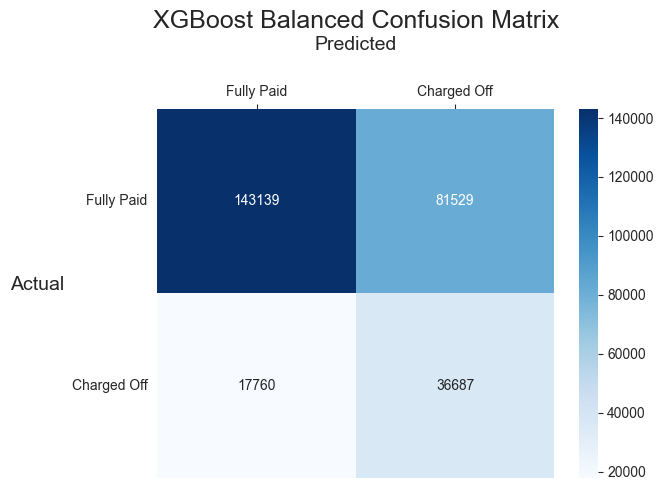

In [105]:
plot_confusion_matrix(y_test, all_model_predictions['xgboost_balanced'], plot_title = 'XGBoost Balanced Confusion Matrix')

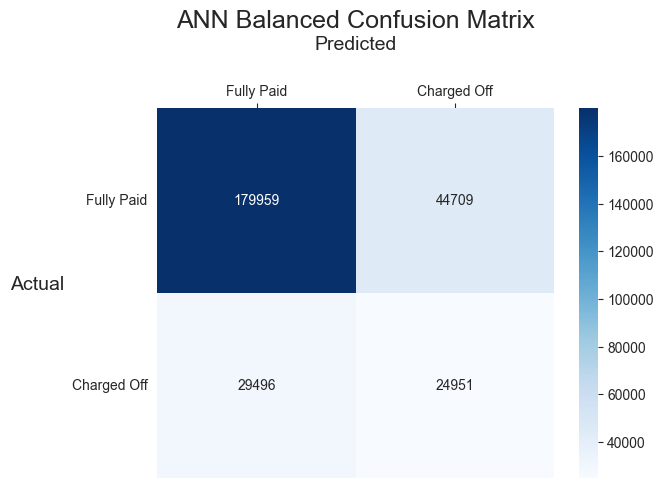

In [106]:
plot_confusion_matrix(y_test, all_model_predictions['ann_balanced'], plot_title = 'ANN Balanced Confusion Matrix')

#### ---- ANN Validation Loss and AUC-ROC Curves ----

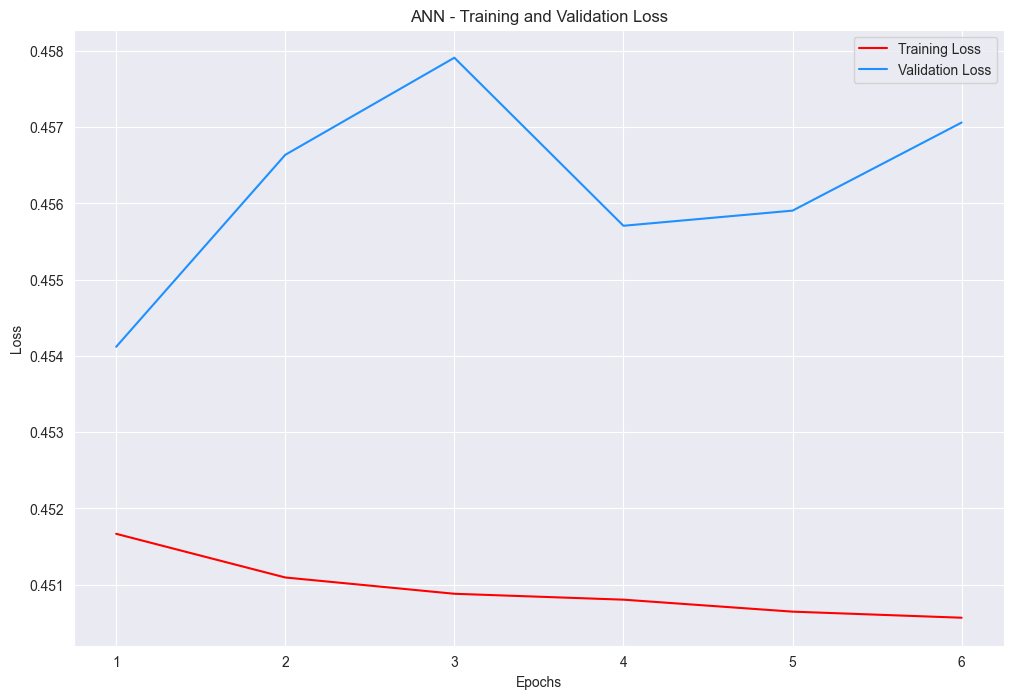

In [217]:
# Imbalanced loss
loss = ann_history.history['loss']
val_loss = ann_history.history['val_loss']

# Plot the loss curve
ep = range(1, len(loss) + 1)
plt.figure(figsize = (12, 8))
plt.plot(ep, loss, 'r', label = 'Training Loss')
plt.plot(ep, val_loss, 'dodgerblue', label = 'Validation Loss')
plt.title('ANN - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

8723/8723 [==============================] - 17s 2ms/step


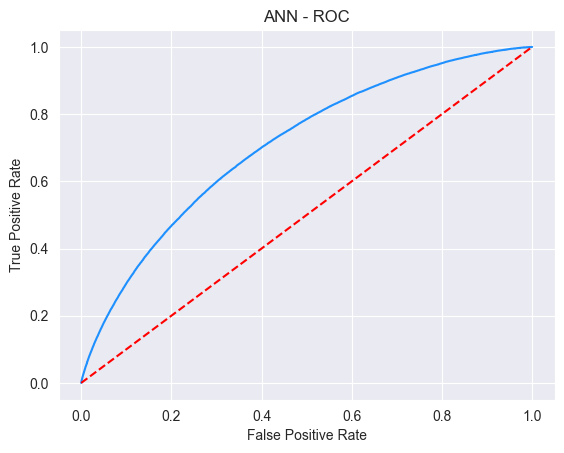

In [218]:
# Get the predicted probabilities for your validation data
y_val_prob = ann_history.model.predict(x_val)
# Calculate the AUC score
auc_score = roc_auc_score(y_val, y_val_prob)

# Plot the AUC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
plt.plot(fpr, tpr, 'dodgerblue')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ANN - ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

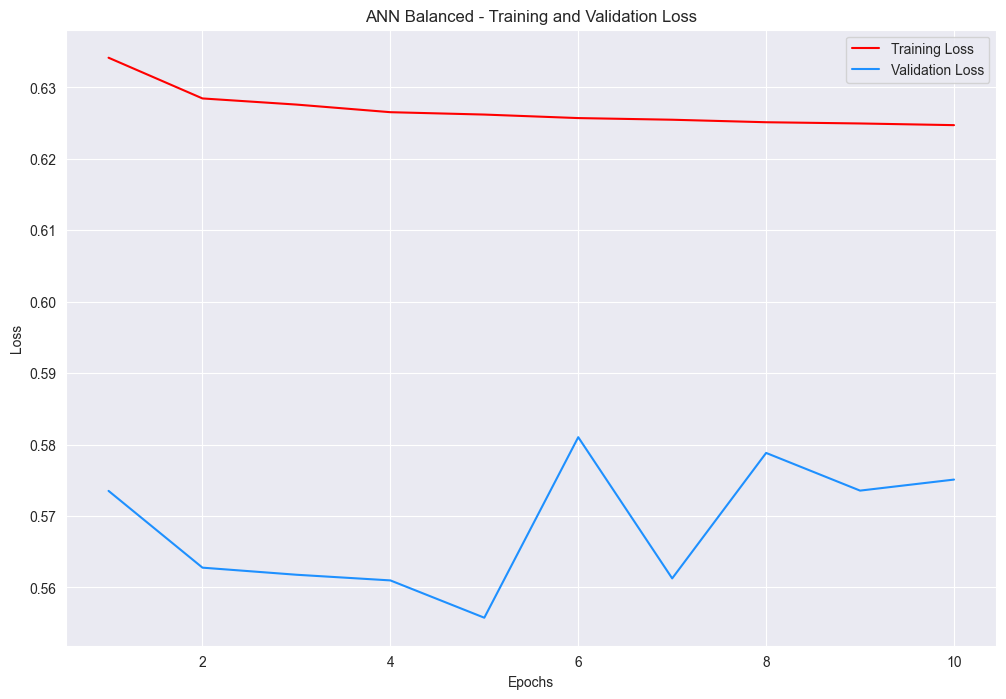

In [176]:
# Balanced loss
loss_balanced = ann_balanced_history.history['loss']
val_loss_balanced = ann_balanced_history.history['val_loss']

# Plot the loss curve
ep = range(1, len(loss_balanced) + 1)
plt.figure(figsize = (12, 8))
plt.plot(ep, loss_balanced, 'r', label = 'Training Loss')
plt.plot(ep, val_loss_balanced, 'dodgerblue', label = 'Validation Loss')
plt.title('ANN Balanced - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

8723/8723 [==============================] - 18s 2ms/step


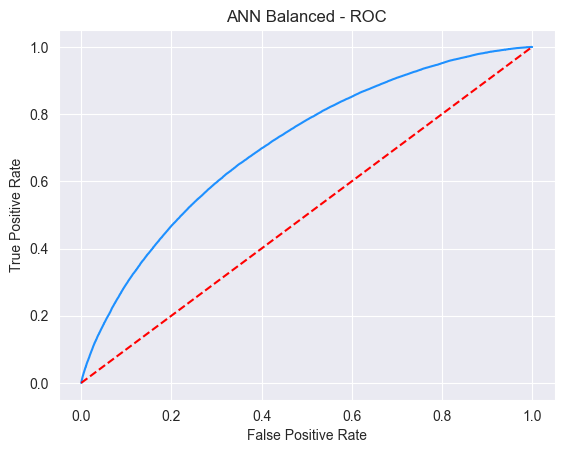

In [179]:
# Get the predicted probabilities for your validation data
y_val_prob = ann_balanced_history.model.predict(x_val)
# Calculate the AUC score
auc_score = roc_auc_score(y_val, y_val_prob)

# Plot the AUC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
plt.plot(fpr, tpr, 'dodgerblue')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ANN Balanced - ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()